In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from ipywidgets import interact
import ipywidgets as ipyw

In [2]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: rgba(18, 105, 138, 0.9);
  font-family: "News Cycle", sans-serif;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: rgba(255, 128, 0, 0.9);
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2); }

</style>

In [3]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "False",
              "progress": "False",
});


<center><img src="imagenes/logo.png", width=600><center>

<br>
<br>
<br>
<br>
<br>
**<center>Workshop en Técnicas de Programación Científica 2018<center>**

<center><img src="imagenes/grupo.jpg", width=800><center>

<center><img src="imagenes/BIOS.png", width=550><center>

## Objetivos

<br>

* **Contarles un poco de la filosofía Bayesiana**
<br>
<br>

* **Presentarles a PyMC3**
<br>

## Mentiras, malditas mentiras y estadísticas

<br>

> Tome una lata de la alacena-estadística. Abra la lata, agrege datos
a gusto y revuelva hasta que la consistencia del _p-valor_ sea 0,05.

* La mayoría de los cursos de estadística se enseñan como una colección de recetas
* En este tipo de cursos el foco está en elegir la lata _correcta_
* Existe otra aproximación, considerar a la **estadística como una forma de modelado**

### Modelado probabilístico*

1. Los modelos se construyen usando como _bloques_ distribuciones de probabilidad

2. Las probabilidades representan la incerteza que tenemos sobre los parámetros del modelo

3. Los parámetros se actualizan a partir de datos usando el teorema de Bayes


\* También llamado estadística Bayesiana, modelado Bayesiano, _machine learning_ probabilístico...

### Teorema de Bayes

$$p(\theta \mid y) = \frac{p(y \mid \theta) {\:} p(\theta)}{\color{gray}{p(y)}}$$

* $\theta$ : parámetros desconocidos, lo que quiero averiguar
* $y$ : los datos


* $p(\theta \mid y)$ : _a posteriori_ 
* $p(y \mid \theta)$ : _likelihood (verosimilitud)_ 
* $p(\theta)$ : _a priori_
* $\color{gray}{p(y) = \int_{\theta} p(y \mid \theta)p(\theta) d(\theta)}$: _evidencia (likelihood marginal)_

### El infaltable problema de la moneda

* Conseguimos datos (tiramos la moneda al aire varias veces)
  
* Pensamos como los datos se podrían haber generado (creamos el modelo)

* _Condicionamos_ el modelo a los datos (teorema de Bayes)

In [4]:
def binomial(n, θ):
    bino = stats.binom(n, θ)
    plt.bar(range(n+1), bino.pmf(range(n+1)))
    plt.xticks(range(n+1))
    plt.ylim(0, 1);

interact(binomial, n=ipyw.IntSlider(min=1, max=10, value=1), θ=ipyw.FloatSlider(min=0, max=1, step=0.05, value=0.5));

A Jupyter Widget

In [5]:
def beta(α, β):
    x = np.linspace(0, 1, 130)
    beta = stats.beta(α, β)
    plt.plot(x, beta.pdf(x))
    plt.yticks([])
    plt.ylim(0, 6)

interact(beta,
         α =ipyw.FloatSlider(min=0.5, max=7, step=0.5, value=2),
         β =ipyw.FloatSlider(min=0.5, max=7, step=0.5, value=2));

A Jupyter Widget

<center><img src="imagenes/modelo_moneda.png" width=300></center>

## Versión analítica
<br>

> Para ciertas combinaciones de _a priori_ y _likelihood_ es posible calcular el _a posteriori_ analíticamente

<br>

<center>Si el _a priori_ es $\mathbf{beta(\alpha, \beta)}$,

<center>y el _likelihood_ $\mathbf{binomial(n)}$,

<center>entonces el posterior es $\mathbf{beta (\alpha + y , \beta + n - y )}$

<center><img src="imagenes/coin_update_0.png" width=600></center>

<center><img src="imagenes/coin_update_1.png" width=600>

**La estadística Bayesina es conceptualmente _simple_ :-)  **
* Está basada en primeros principio --> es una consecuencia directa de la teoría de probabilidad.
* Los datos permiten actualizar el _a priori_ obteniéndose el _a posteriori_.
* El _a posteriori_ se usa para calcular todo lo que nos interesa, medias, desviaciones estándar, cuantiles, intervalos de credibilidad, predicciones, etc.
 
**La estadística Bayesina es matemáticamente _difícil_ :-(  **
* Solo un reducido número de modelos tiene solución analítica.
* Es necesario utilizar métodos numéricos.

## Método de la Grilla

<br>

<center><img src="imagenes/vaca.png" width=500></center>

In [6]:
def posterior_grid(grilla=10, α=1, β=1, caras=6, tiradas=9):
    grid = np.linspace(0, 1, grilla)
    prior = stats.beta(α, β).pdf(grid)
    likelihood = stats.binom.pmf(caras, tiradas, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
    ax[0].set_title('caras = {}\ntiradas = {}'.format(caras, tiradas))
    for i, (e, e_n) in enumerate(zip([prior, likelihood, posterior], ['prior', 'likelihood', 'posterior'])):
        ax[i].set_yticks([])
        ax[i].plot(grid, e, 'o-', label=e_n)
        ax[i].legend(fontsize=14)

interact(posterior_grid, grilla=ipyw.IntSlider(min=2, max=100, step=1, value=15), α=ipyw.FloatSlider(min=1, max=7, step=1, value=1), β=ipyw.FloatSlider(min=1, max=7, step=1, value=1), caras=ipyw.IntSlider(min=0, max=20, step=1, value=6),tiradas=ipyw.IntSlider(min=0, max=20, step=1, value=9));

A Jupyter Widget

###  Motores de inferencia

* Métodos como el de la grilla no escalan bien a medida que aumentan la cantidad de parámetros a inferir



* En teoría existen **Motores de Inferencia Universal**
    * Markov Chain Monte Carlo (MCMC)
        * Genera muestras de la distribución correcta (_a posteriori_)
        * Algunos de los métodos más usados:
            * Metropolis-Hastings
            * Monte Carlo Hamiltoniano (NUTS)
            * Sequential Monte Carlo

    * Métodos Variacionales (VI)
        * Obtiene una distribución exacta que aproxima la correcta (_a posteriori_)

## PyMC3: Programación probabilística en Python
<br>

<center><a href="http://docs.pymc.io/"><img src="imagenes/PyMC3_banner.svg" width=500></center>


* Métodos modernos de inferencia, incluyendo MCMC y VI
* Una gran colección de distribuciones estadísticas
* Usa Theano como _computational backend_: Velocidad, cálculo automático de gradientes, optimizaciones _matemáticas_, soporte para GPU
* Funciones para vizualizar y analizar el _posterior_
* Funciones para evaluar convergencia y validar modelos
* Soporte para métodos no paramétricos: Procesos Gaussianos para regresión y clasificación. Procesos de Dirichlet próximamente



In [7]:
datos = [0] * 7 + [1] * 11

with pm.Model() as modelo_m:
    theta = pm.Beta('theta', 1., 1.)
    likelihood = pm.Bernoulli('likelihood', theta, observed=datos)
    trace_m = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_logodds__]
100%|██████████| 1500/1500 [00:01<00:00, 1116.47it/s]


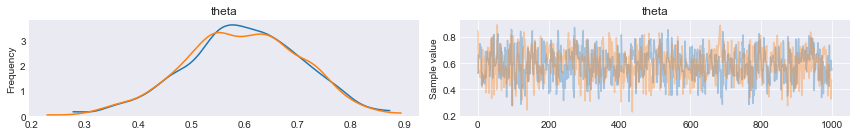

In [8]:
pm.traceplot(trace_m);

In [9]:
pm.forestplot(trace_m);

In [10]:
pm.summary(trace_m).round(2)

mean    sd  mc_error  hpd_2.5  hpd_97.5   n_eff  Rhat
theta  0.59  0.11       0.0     0.38      0.81  742.05   1.0

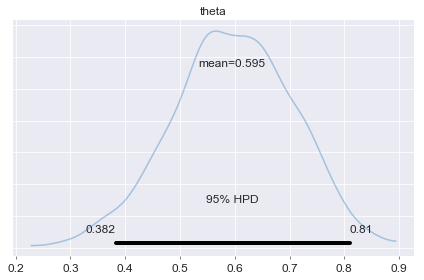

In [11]:
pm.plot_posterior(trace_m, kde_plot=True, text_size=12);

100%|██████████| 100/100 [00:00<00:00, 1266.99it/s]


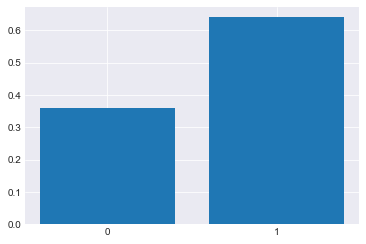

In [12]:
datos_sintéticos = pm.sample_ppc(trace_m, 100, modelo_m)
p =  datos_sintéticos['likelihood'].mean()
plt.bar([0, 1], [1-p, p])
plt.xticks([0, 1]);

## Accidentes mineros

* Tenemos un registro de accidentes mineros en Reino Unido, desde 1962.
* Se cree que cambios en la regulación respecto de la seguridad tuvieron un efecto positivo (menos accidentes)
* Queremos determinar cuando ocurrió esta disminución de accidentes
* Para algunos años tenemos datos perdidos (marcados como -999)

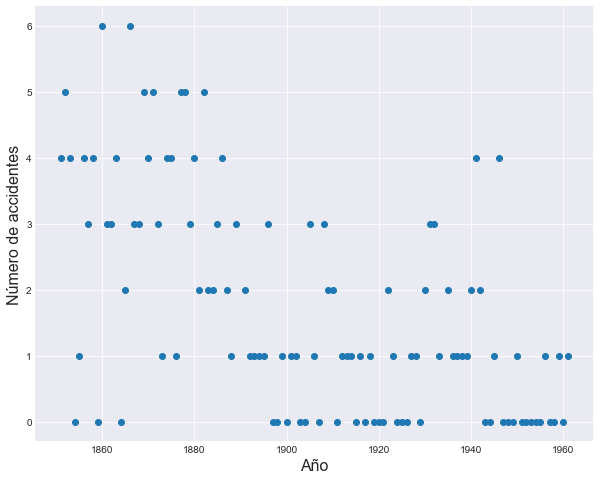

In [13]:
datos = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
años = np.arange(1851, 1962)
plt.figure(figsize=(10, 8))
plt.plot(años, datos, 'o')
plt.ylabel("Número de accidentes", fontsize=16)
plt.xlabel("Año", fontsize=16);

<center><img src="imagenes/accidentes_mineros.png" width=400>

In [14]:
with pm.Model() as modelo_am:

    pc = pm.DiscreteUniform('pc', lower=años.min(), upper=años.max(), testval=1900)

    tasa_0 = pm.Exponential('tasa_0', 1)
    tasa_1 = pm.Exponential('tasa_1', 1)

    tasa = pm.math.switch(pc >= años, tasa_0, tasa_1)

    accidentes = pm.Poisson('accidentes', tasa, observed=datos)

    trace_am = pm.sample(1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [accidentes_missing]
>>Metropolis: [pc]
>NUTS: [tasa_1_log__, tasa_0_log__]
100%|██████████| 1500/1500 [00:08<00:00, 171.98it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


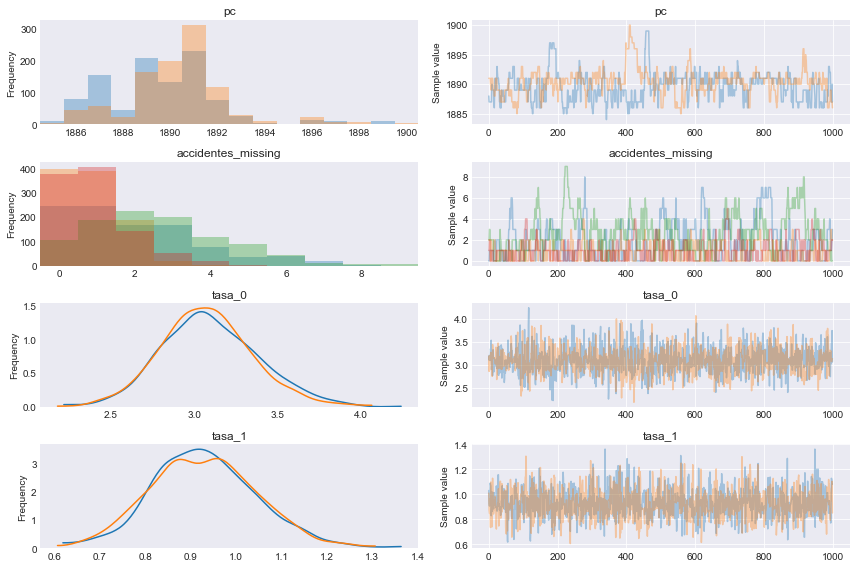

In [15]:
pm.traceplot(trace_am);

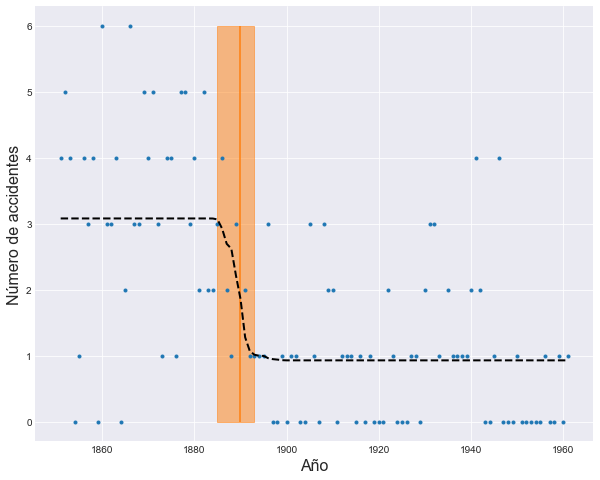

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(años, datos, '.')
plt.ylabel("Número de accidentes", fontsize=16)
plt.xlabel("Año", fontsize=16)

plt.vlines(trace_am['pc'].mean(), datos.min(), datos.max(), color='C1')
accidentes_promedio = np.zeros_like(datos, dtype='float')
for i, año in enumerate(años):
    idx = año < trace_am['pc']
    accidentes_promedio[i] = (trace_am['tasa_0'][idx].sum() + trace_am['tasa_1'][~idx].sum()) / (len(trace_am) * trace_am.nchains)

pc_hpd = pm.hpd(trace_am['pc'])
plt.fill_betweenx(y=[datos.min(), datos.max()], x1=pc_hpd[0], x2=pc_hpd[1], alpha=0.5, color='C1');
plt.plot(años, accidentes_promedio,  'k--', lw=2);

### Regresión lineal

Versión familiar:

$$y_i = \alpha + \beta x_i $$

Versión probabilista:

$$ Y \sim \mathcal{N}(\alpha + \beta X,\: \sigma) $$

Los datos $Y$ son generados siguiendo una distribución Gausiana con media $\alpha + \beta X$ y desviación estándar $\sigma$.

Como $\alpha$, $\beta$ y $\sigma$ son cantidades desconocidas ponemos un _ a priori_ sobre ellos.

<center><img src="imagenes/Regresion_lineal_modelo.png" width=400>

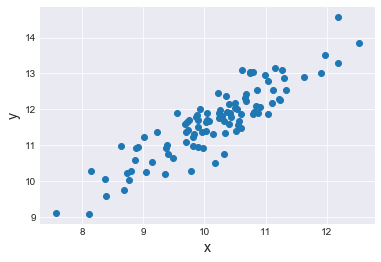

In [17]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
# y = a + b*x + e
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

plt.scatter(x, y);
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14);

In [18]:
with pm.Model() as modelo_rl:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    σ = pm.HalfNormal('σ', 50)
    μ = pm.Deterministic('μ', α + β * x)
    
    y_pred = pm.Normal('y_pred', mu=μ, sd=σ, observed=y)
    
    trace_rl = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ_log__, β, α]
100%|██████████| 1500/1500 [00:13<00:00, 115.08it/s]


In [19]:
pm.traceplot(trace_rl);

100%|██████████| 231/231 [00:00<00:00, 576.94it/s]


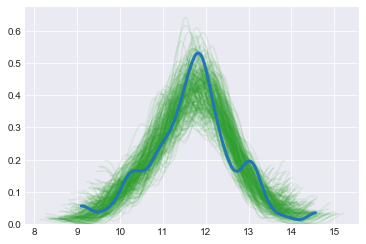

In [20]:
ppc = pm.sample_ppc(trace_rl, samples=231, model=modelo_rl)
_, ax = plt.subplots()
# datos predichos
for y_tilde in ppc['y_pred']:
    pm.kdeplot(y_tilde, alpha=0.1, c='C2', ax=ax);
# datos reales
pm.kdeplot(y, linewidth=3, ax=ax);

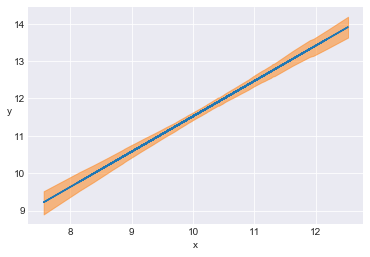

In [21]:
α_m = trace_rl['α'].mean()
β_m = trace_rl['β'].mean()

plt.plot(x, α_m + β_m * x, label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_rl['μ'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='C1', alpha=0.5)

plt.xlabel('x')
plt.ylabel('y', rotation=0);

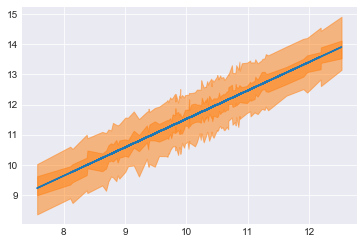

In [22]:
plt.plot(x, α_m + β_m*x, label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='C1', alpha=0.5);
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='C1', alpha=0.5);

### Regresión lineal, versión robusta

<br>

* ¿Qué hacer cuando tenemos datos aberrantes?
    * Modificar los datos (eliminarlos)
    * Modificar el modelo

<br>

Si el problema es que hay datos _más lejos_ de lo que _espera_ el modelo, entonces usemos un modelo que espere datos _alejados_!

In [23]:
# Cuarteto de Anscombe (3 conjunto de datos)
x_3 = np.array([10.0, 8.0, 13.0, 9.0, 11.0, 14.0, 6.0, 4.0, 12.0, 7.0, 5.0])
y_3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])

plt.scatter(x_3, y_3);

#### Disribución T de Student


* Es una generalización de la Gaussiana
* $\nu$ controla cuan _pesadas son las colas_

<img alt="StudentT" src="imagenes/StudentT.png", width=600>

<center><img alt="regresión_lineal_robusta" src="imagenes/reg_lineal_robusta.png", width=500>

In [24]:
with pm.Model() as modelo_t:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10)
    σ = pm.HalfNormal('σ', 25)
    ν = pm.Exponential('ν', 1/30) + 1
    y_pred = pm.StudentT('y_pred', mu=α + β * x_3, sd=σ, nu=ν, observed=y_3)

    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_log__, σ_log__, β, α]
100%|██████████| 2500/2500 [00:19<00:00, 126.93it/s]


In [25]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
β_c, α_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (α_c + β_c* x_3), label='no-robusta');
plt.scatter(x_3, y_3, color='C2');
α_m = trace_t['α'].mean()
β_m = trace_t['β'].mean()
plt.plot(x_3, α_m + β_m*x_3, c='C1', label='robusta')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12);
plt.tight_layout()

## Regresión lineal jerárquica

* En muchos problemas tenemos información a nivel de grupos que se agregan para generar un todo
    * desempeño estudiantes por escuela --> desempeño por provincia --> desempeño nacional
    * 20 aminoácidos --> una proteína
    
* La estrategía más común es analizar grupos por separado o agregar los grupos
* Los modelos jerárquicos permiten hacer algo intermedio

In [26]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)

α_real = np.random.normal(2.5, 0.5, size=M)
β_real = np.random.beta(0.9*100, 0.1*100, size=M)
σ_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
x_m -= x_m.mean()
y_m = α_real[idx] + β_real[idx] * x_m  + σ_real

In [27]:
j, k = 0, N
for i in range(M):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlim(-4, 4)
    plt.ylim(-1, 8)
    j += N
    k += N
plt.tight_layout()

 <center><img alt="regresión_lineal_simple" src="imagenes/regresion_lineal_robusta_jerarquica.png", width=500>

In [28]:

with pm.Model() as modelo_agrupado:
    # hyper-priors
    α_mu = pm.Normal('α_mu', mu=0, sd=10)
    α_sd = pm.HalfNormal('α_sd', 25)
    β_mu = pm.Normal('β_mu', mu=0, sd=10)
    β_sd = pm.HalfNormal('β_sd', 25)

    # a prioris
    α = pm.Normal('α', mu=α_mu, sd=α_sd, shape=M)
    β = pm.Normal('β', mu=β_mu, sd=β_sd, shape=M)
    σ = pm.HalfNormal('σ', 25)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α[idx] + β[idx] * x_m, sd=σ, nu=ν, observed=y_m)


    trace_a = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_log__, σ_log__, β, α, β_sd_log__, β_mu, α_sd_log__, α_mu]
100%|██████████| 2500/2500 [00:14<00:00, 173.93it/s]
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 155 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.709932218569, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [29]:
#pm.traceplot(trace_a);

In [30]:
#pm.df_summary(trace_a, varnames)

In [31]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    α_m = trace_a['α'][:,i].mean()
    β_m = trace_a['β'][:,i].mean()
    plt.plot(x_range,
             α_m + β_m * x_range,
             c='C1',
             label='y = {:.2f} + {:.2f} * x'.format(α_m, β_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    #print(stats.linregress(x_m[j:k], y_m[j:k])[:2])
    j += N
    k += N
plt.tight_layout()

## PyMC3 + Bomeba 



Modelar probabilísticamente moleculas requiere dos partes
* Una parte probabilista (PyMC3)
    * Esencialmente lo que ya vimos
* Una parte molecular (Bomeba)
    * Clases para representar moléculas
    * Cálculo de propiedas como la energía, observables experimentales, etc
    * Transformación entre coordenas internas y cartesianas
    * Visualizaciones

<center><img src="imagenes/2KQO_cartoon.png" width=300>
<center><img src="imagenes/krusche_simplified_bomeba.png" width=500>